In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Here I would like to try to do cross domain on Generative Adversial Network Tensorflow

Below is Ian GoodFellow Model,
![screenshot](http://blog.aylien.com/wp-content/uploads/2016/08/gan.png)

This is what cross-domain GAN do
![screenshot](https://qph.ec.quoracdn.net/main-qimg-f1a8b738ec0427663a66101408ef67ae)

In [2]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We gonna combine Sneaker[7] with Shirt[6], let see how it goes :)

In [3]:
# first 3000 sneakers
sneakers = df.loc[df['label'] == 7].iloc[:3000, 1:].values.copy()
sneakers = sneakers / 255.0
# first 3000 shirts
shirt = df.loc[df['label'] == 6].iloc[:3000, 1:].values.copy()
shirt = shirt / 255.0

sneakers = sneakers.reshape((-1, 28, 28, 1))
shirt = shirt.reshape((-1, 28, 28, 1))

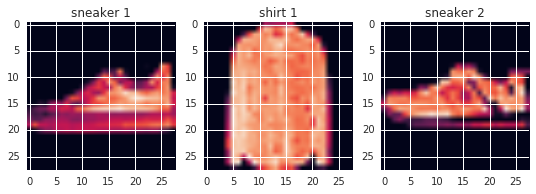

In [4]:
# example print image
fig = plt.figure(figsize = (9, 3))
plt.subplot(1, 3, 1)
plt.imshow(sneakers[0, :, :, :].reshape((28, 28)))
plt.title('sneaker 1')
plt.subplot(1, 3, 2)
plt.imshow(shirt[0, :, :, :].reshape((28, 28)))
plt.title('shirt 1')
plt.subplot(1, 3, 3)
plt.imshow(sneakers[1, :, :, :].reshape((28, 28)))
plt.title('sneaker 2')
plt.show()

Lovely! Now let's create a function that able to print a lot of samples

In [5]:
def generate_sample(samples):
    # take first 16 samples
    idx = [i for i in range(16)]
    fig, axes = plt.subplots(4, 4, sharex = True, sharey = True, figsize = (5,5))

    for ii, ax in zip(idx, axes.flatten()):
        ax.imshow(samples[ii,:].reshape((28, 28)), aspect = 'equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()

Define our distribution noise, generator, discriminate function

also huber loss,
![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/e384efc4ae2632cb0bd714462b7c38c272098cf5)

Why need huber loss? Based from original paper,
![alt text](https://raw.githubusercontent.com/huseinzol05/Deep-Learning-Tensorflow/master/DiscoGAN/discogan.png)

For this reason, we minimize the distance d(GBA ◦ GAB(xA), xA), where any form of metric function (L1, L2, Huber loss) can be used. Similarly, we also need to minimize d(GAB ◦ GBA(xB), xB)

We only create (C) model for this time, called discoGAN

![alt text](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)
he Huber loss is a loss function used in robust regression, that is less sensitive to outliers in data than the squared error loss. Simply said, to prevent the generator generated something out of the boundary from the 2 domains

In [6]:
# compress size
encoding_dim = 256
# 28 * 28
image_size = 784

def huber_loss(logits, labels, max_gradient = 1.0):
    err = tf.abs(labels - logits)
    mg = tf.constant(max_gradient)
    lin = mg * (err - 0.5 * mg)
    quad = 0.5 * err * err
    return tf.where(err < mg, quad, lin)

# multi-perceptron encoder
def generator(z, name, reuse = False, training = True):
    with tf.variable_scope(name, reuse = reuse):
        conv1 = tf.layers.conv2d(z, 16, (3, 3), padding = 'same', activation = tf.nn.relu)
        maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding = 'same')
        conv2 = tf.layers.conv2d(maxpool1, 8, (3, 3), padding = 'same', activation = tf.nn.relu)
        maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2, 2), padding = 'same')
        conv3 = tf.layers.conv2d(maxpool2, 8, (3, 3), padding = 'same', activation = tf.nn.relu)
        encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding = 'same')
        upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
        conv4 = tf.layers.conv2d(upsample1, 8, (3, 3), padding = 'same', activation = tf.nn.relu)
        upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
        conv5 = tf.layers.conv2d(upsample2, 8, (3, 3), padding = 'same', activation = tf.nn.relu)
        upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
        conv6 = tf.layers.conv2d(upsample3, 16, (3, 3), padding = 'same', activation = tf.nn.relu)
        logits = tf.layers.conv2d(conv6, 1, (3, 3), padding = 'same', activation = None)
        return tf.nn.sigmoid(logits)
        
def discriminator(z, name, reuse = False):
    with tf.variable_scope(name, reuse = reuse):
        x1 = tf.layers.conv2d(z, 8, 5, strides = 2, padding = 'same')
        relu1 = tf.nn.relu(x1)
        x2 = tf.layers.conv2d(relu1, 64, 5, strides = 2, padding = 'same')
        relu2 = tf.nn.relu(x2)
        x3 = tf.layers.conv2d(relu2, 128, 5, strides = 2, padding = 'same')
        relu3 = tf.nn.relu(x3)
        flat = tf.reshape(relu3, (-1, 4 * 4 * 128))
        return tf.layers.dense(flat, 1)

In [7]:
class discoGAN:
    # set learning rate here
    def __init__(self, learning_rate = 1e-6):
        # first domain
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1))
        # second domain
        self.Y = tf.placeholder(tf.float32, (None, 28, 28, 1))
        g_AB_model = generator(self.X, 'generator_AB')
        g_BA_model = generator(self.Y, 'generator_BA')
        self.g_out_AB = generator(self.X, 'generator_AB', reuse = True, training = False)
        self.g_out_BA = generator(self.Y, 'generator_BA', reuse = True, training = False)
        g_huber_A = generator(g_AB_model, 'generator_BA', reuse = True)
        g_huber_B = generator(g_BA_model, 'generator_AB', reuse = True)
        l_const_a = tf.reduce_mean(huber_loss(g_huber_A, self.X))
        l_const_b = tf.reduce_mean(huber_loss(g_huber_B, self.Y))
        d_logits_real_A = discriminator(self.Y, 'discriminator_A')
        d_logits_fake_A = discriminator(g_AB_model, 'discriminator_A', reuse = True)
        d_logits_real_B = discriminator(self.X, 'discriminator_B')
        d_logits_fake_B = discriminator(g_BA_model, 'discriminator_B', reuse = True)
        
        # ian goodfellow cost function, policy based
        d_loss_real_A = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real_A, 
                                                                               labels = tf.ones_like(d_logits_real_A)))
        d_loss_fake_A = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_A, 
                                                                               labels = tf.zeros_like(d_logits_fake_A)))
        # maximise generatorAB output
        self.g_loss_AB = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_A, 
                                                                                labels = tf.ones_like(d_logits_real_A)))
        
        d_loss_real_B = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real_B, 
                                                                               labels = tf.ones_like(d_logits_real_B)))
        d_loss_fake_B = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_B, 
                                                                               labels = tf.zeros_like(d_logits_fake_B)))
        # maximise generatorBA output
        self.g_loss_BA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake_B, 
                                                                                labels = tf.ones_like(d_logits_real_B)))
        
        self.d_loss = d_loss_real_A + d_loss_fake_A + d_loss_real_B + d_loss_fake_B
        self.g_loss = self.g_loss_AB + self.g_loss_BA + l_const_a + l_const_b
        
        t_vars = tf.trainable_variables()
        d_vars_A = [var for var in t_vars if var.name.startswith('discriminator_A')]
        d_vars_B = [var for var in t_vars if var.name.startswith('discriminator_B')]
        g_vars_AB = [var for var in t_vars if var.name.startswith('generator_AB')]
        g_vars_BA = [var for var in t_vars if var.name.startswith('generator_BA')]
        
        self.d_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.d_loss, var_list = d_vars_A + d_vars_B)
        self.g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = 0.999, beta2 = 0.999).minimize(self.g_loss, var_list = g_vars_AB + g_vars_BA)

In [8]:
def train(model, X, Y, batch, epoch):
    LOSS_D, LOSS_G = [], []
    for i in range(epoch):
        g_loss, d_loss = 0, 0
        for k in range(0, (X.shape[0] // batch) * batch, batch):
            batch_x = X[k: k + batch, :, :, :]
            batch_y = Y[k: k + batch, :, :, :]
            _, lossd = sess.run([model.d_train_opt, model.d_loss], 
                                feed_dict = {model.X: batch_x, model.Y: batch_y})
            _, lossg = sess.run([model.g_train_opt, model.g_loss], 
                                feed_dict = {model.X: batch_x, model.Y: batch_y})
            g_loss += lossg
            d_loss += lossd
        g_loss /= (X.shape[0] // batch)
        d_loss /= (X.shape[0] // batch)
        print("Epoch {}/{}".format(i + 1, EPOCH), 
              "Discriminator Loss: {}".format(d_loss), 
              "Generator Loss: {}".format(g_loss))
        LOSS_G.append(g_loss); LOSS_D.append(d_loss)
        
        if (i + 1) % 10 == 0:
            # 16 pictures because our sample function above only accept 16 samples
            batch_x = X[:16, :, :, :]
            batch_y = Y[:16, :, :, :]
            outputs = sess.run(model.g_out_AB, feed_dict = {model.X: batch_x})
            print('GENERATOR A')
            generate_sample(outputs)
            print('GENERATOR B')
            outputs = sess.run(model.g_out_BA, feed_dict = {model.Y: batch_y})
            generate_sample(outputs)
    
    epoch = [i for i in range(len(LOSS_D))]
    plt.plot(epoch,LOSS_D, label = 'Discriminator', alpha = 0.5)
    plt.plot(epoch, LOSS_G, label = 'Generator', alpha = 0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

Epoch 1/100 Discriminator Loss: 2.770637356440226 Generator Loss: 1.590532374382019
Epoch 2/100 Discriminator Loss: 2.770558648109436 Generator Loss: 1.5904633506139119
Epoch 3/100 Discriminator Loss: 2.770478097597758 Generator Loss: 1.5903965512911478
Epoch 4/100 Discriminator Loss: 2.7703958813349407 Generator Loss: 1.5903303805987041
Epoch 5/100 Discriminator Loss: 2.7703120613098147 Generator Loss: 1.5902647217114767
Epoch 6/100 Discriminator Loss: 2.770226640701294 Generator Loss: 1.5902001404762267
Epoch 7/100 Discriminator Loss: 2.7701395829518636 Generator Loss: 1.5901356323560079
Epoch 8/100 Discriminator Loss: 2.7700509277979535 Generator Loss: 1.5900717719395956
Epoch 9/100 Discriminator Loss: 2.769960838953654 Generator Loss: 1.5900075769424438
Epoch 10/100 Discriminator Loss: 2.7698695786794025 Generator Loss: 1.5899423162142436
GENERATOR A


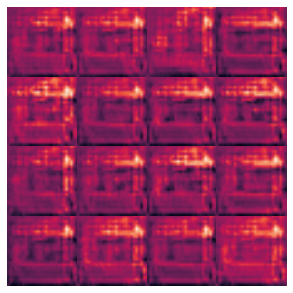

GENERATOR B


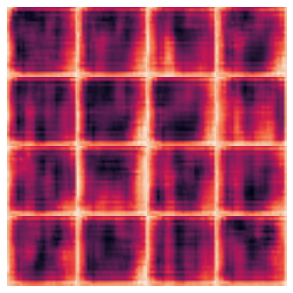

Epoch 11/100 Discriminator Loss: 2.769777318636576 Generator Loss: 1.5898761542638142
Epoch 12/100 Discriminator Loss: 2.769684322675069 Generator Loss: 1.5898085308074952
Epoch 13/100 Discriminator Loss: 2.769590595563253 Generator Loss: 1.5897393314043682
Epoch 14/100 Discriminator Loss: 2.7694961818059287 Generator Loss: 1.589668731689453
Epoch 15/100 Discriminator Loss: 2.7694009590148925 Generator Loss: 1.5895966903368632
Epoch 16/100 Discriminator Loss: 2.76930521329244 Generator Loss: 1.5895227026939391
Epoch 17/100 Discriminator Loss: 2.7692091989517214 Generator Loss: 1.5894463443756104
Epoch 18/100 Discriminator Loss: 2.7691131099065145 Generator Loss: 1.5893674453099569
Epoch 19/100 Discriminator Loss: 2.7690168523788454 Generator Loss: 1.589285306930542
Epoch 20/100 Discriminator Loss: 2.768920397758484 Generator Loss: 1.5891996081670126
GENERATOR A


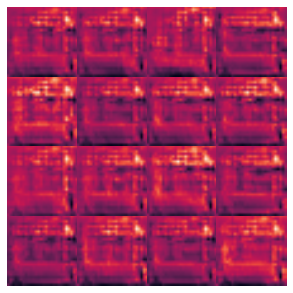

GENERATOR B


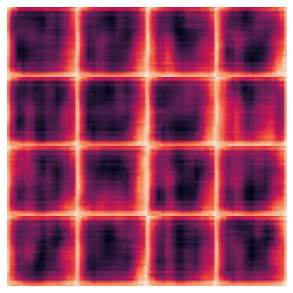

Epoch 21/100 Discriminator Loss: 2.7688236951828005 Generator Loss: 1.589109472433726
Epoch 22/100 Discriminator Loss: 2.7687266874313354 Generator Loss: 1.5890148838361104
Epoch 23/100 Discriminator Loss: 2.768629479408264 Generator Loss: 1.5889160418510437
Epoch 24/100 Discriminator Loss: 2.768532249132792 Generator Loss: 1.588812399705251
Epoch 25/100 Discriminator Loss: 2.7684350935618083 Generator Loss: 1.5887025284767151
Epoch 26/100 Discriminator Loss: 2.768338123957316 Generator Loss: 1.5885870019594828
Epoch 27/100 Discriminator Loss: 2.76824125289917 Generator Loss: 1.588466124534607
Epoch 28/100 Discriminator Loss: 2.7681445121765136 Generator Loss: 1.5883397189776103
Epoch 29/100 Discriminator Loss: 2.7680478143692016 Generator Loss: 1.5882073497772218
Epoch 30/100 Discriminator Loss: 2.767951153119405 Generator Loss: 1.5880684351921082
GENERATOR A


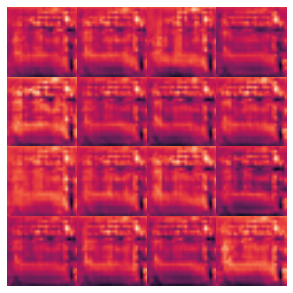

GENERATOR B


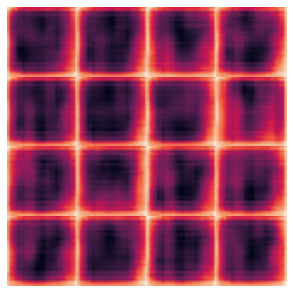

Epoch 31/100 Discriminator Loss: 2.767854625384013 Generator Loss: 1.5879223076502482
Epoch 32/100 Discriminator Loss: 2.7677583440144855 Generator Loss: 1.587768834431966
Epoch 33/100 Discriminator Loss: 2.7676624123255413 Generator Loss: 1.5876072430610657
Epoch 34/100 Discriminator Loss: 2.7675669685999553 Generator Loss: 1.5874380747477213
Epoch 35/100 Discriminator Loss: 2.7674720605214436 Generator Loss: 1.587260819276174
Epoch 36/100 Discriminator Loss: 2.767377821604411 Generator Loss: 1.5870750912030538
Epoch 37/100 Discriminator Loss: 2.7672843742370605 Generator Loss: 1.5868800671895344
Epoch 38/100 Discriminator Loss: 2.767191905975342 Generator Loss: 1.586674776871999
Epoch 39/100 Discriminator Loss: 2.767100451787313 Generator Loss: 1.586460223197937
Epoch 40/100 Discriminator Loss: 2.7670100768407186 Generator Loss: 1.5862364037831624
GENERATOR A


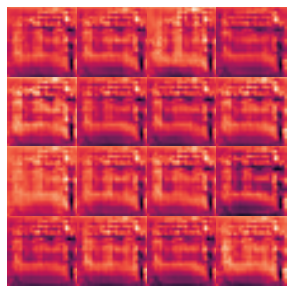

GENERATOR B


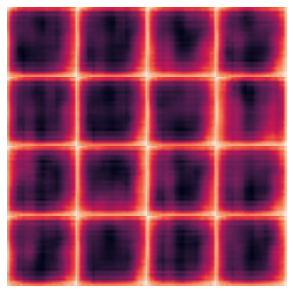

Epoch 41/100 Discriminator Loss: 2.7669208447138467 Generator Loss: 1.5860029514630636
Epoch 42/100 Discriminator Loss: 2.766832853953044 Generator Loss: 1.5857611934343974
Epoch 43/100 Discriminator Loss: 2.7667461506525677 Generator Loss: 1.585510963598887
Epoch 44/100 Discriminator Loss: 2.7666608985265095 Generator Loss: 1.5852500502268474
Epoch 45/100 Discriminator Loss: 2.766577191352844 Generator Loss: 1.5849777030944825
Epoch 46/100 Discriminator Loss: 2.7664950211842854 Generator Loss: 1.5846939794222514
Epoch 47/100 Discriminator Loss: 2.7664144611358643 Generator Loss: 1.5843987210591635
Epoch 48/100 Discriminator Loss: 2.766335433324178 Generator Loss: 1.5840915433565776
Epoch 49/100 Discriminator Loss: 2.7662578852971396 Generator Loss: 1.583772033850352
Epoch 50/100 Discriminator Loss: 2.766181716918945 Generator Loss: 1.58344051917394
GENERATOR A


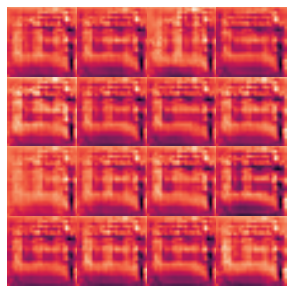

GENERATOR B


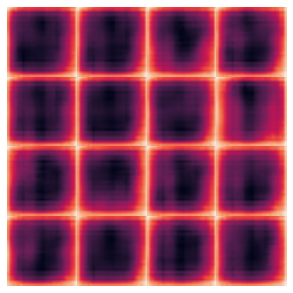

Epoch 51/100 Discriminator Loss: 2.766106767654419 Generator Loss: 1.5830966281890868
Epoch 52/100 Discriminator Loss: 2.766032881736755 Generator Loss: 1.5827405579884848
Epoch 53/100 Discriminator Loss: 2.765959922472636 Generator Loss: 1.582373005549113
Epoch 54/100 Discriminator Loss: 2.7658877738316856 Generator Loss: 1.5819940694173178
Epoch 55/100 Discriminator Loss: 2.765816578865051 Generator Loss: 1.5816027998924256
Epoch 56/100 Discriminator Loss: 2.7657465362548828 Generator Loss: 1.581198771794637
Epoch 57/100 Discriminator Loss: 2.7656777334213256 Generator Loss: 1.580781532128652
Epoch 58/100 Discriminator Loss: 2.7656102244059246 Generator Loss: 1.580351968606313
Epoch 59/100 Discriminator Loss: 2.7655439647038778 Generator Loss: 1.5799080697695413
Epoch 60/100 Discriminator Loss: 2.7654790544509886 Generator Loss: 1.579448126157125
GENERATOR A


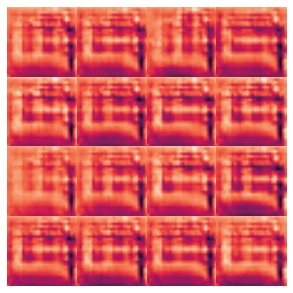

GENERATOR B


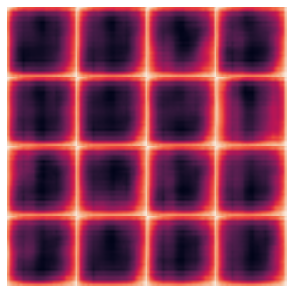

Epoch 61/100 Discriminator Loss: 2.765415596961975 Generator Loss: 1.5789747309684754
Epoch 62/100 Discriminator Loss: 2.7653535731633503 Generator Loss: 1.5784877411524454
Epoch 63/100 Discriminator Loss: 2.7652930196126304 Generator Loss: 1.5779876414934795
Epoch 64/100 Discriminator Loss: 2.7652340157826742 Generator Loss: 1.577474637031555
Epoch 65/100 Discriminator Loss: 2.7651765902837115 Generator Loss: 1.5769485505421956
Epoch 66/100 Discriminator Loss: 2.7651207224527994 Generator Loss: 1.5764095695813496
Epoch 67/100 Discriminator Loss: 2.7650666093826293 Generator Loss: 1.5758568437894185
Epoch 68/100 Discriminator Loss: 2.7650143035252888 Generator Loss: 1.5752896563212078
Epoch 69/100 Discriminator Loss: 2.764963927268982 Generator Loss: 1.574708153406779
Epoch 70/100 Discriminator Loss: 2.764915572802226 Generator Loss: 1.5741124669710795
GENERATOR A


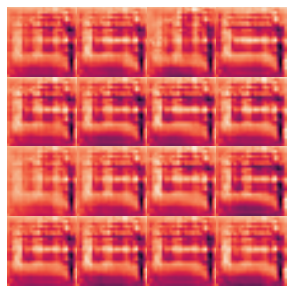

GENERATOR B


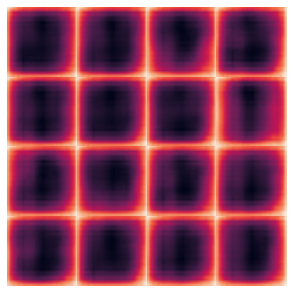

Epoch 71/100 Discriminator Loss: 2.764869434038798 Generator Loss: 1.5735029824574789
Epoch 72/100 Discriminator Loss: 2.7648258034388222 Generator Loss: 1.5728798723220825
Epoch 73/100 Discriminator Loss: 2.7647847954432168 Generator Loss: 1.5722430729866028
Epoch 74/100 Discriminator Loss: 2.764746691385905 Generator Loss: 1.5715923953056334
Epoch 75/100 Discriminator Loss: 2.764711691538493 Generator Loss: 1.570928189754486
Epoch 76/100 Discriminator Loss: 2.7646799278259278 Generator Loss: 1.5702503259976706
Epoch 77/100 Discriminator Loss: 2.764651257197062 Generator Loss: 1.5695593786239623
Epoch 78/100 Discriminator Loss: 2.764625563621521 Generator Loss: 1.5688558650016784
Epoch 79/100 Discriminator Loss: 2.764602770805359 Generator Loss: 1.568136950333913
Epoch 80/100 Discriminator Loss: 2.7645830663045246 Generator Loss: 1.5674031694730124
GENERATOR A


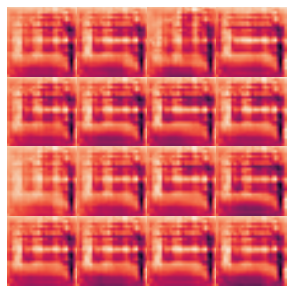

GENERATOR B


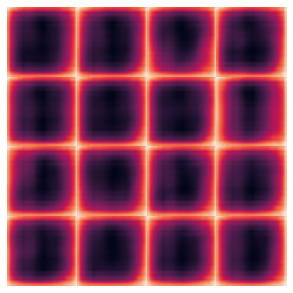

Epoch 81/100 Discriminator Loss: 2.7645665772755943 Generator Loss: 1.566657600402832
Epoch 82/100 Discriminator Loss: 2.764553470611572 Generator Loss: 1.5659016561508179
Epoch 83/100 Discriminator Loss: 2.7645440514882407 Generator Loss: 1.5651358683904013
Epoch 84/100 Discriminator Loss: 2.76453848361969 Generator Loss: 1.5643606758117676
Epoch 85/100 Discriminator Loss: 2.76453687508901 Generator Loss: 1.5635755085945129
Epoch 86/100 Discriminator Loss: 2.764539442062378 Generator Loss: 1.5627801513671875
Epoch 87/100 Discriminator Loss: 2.7645465008417767 Generator Loss: 1.5619768619537353
Epoch 88/100 Discriminator Loss: 2.764558318456014 Generator Loss: 1.5611671010653179
Epoch 89/100 Discriminator Loss: 2.7645751825968423 Generator Loss: 1.5603512128194172
Epoch 90/100 Discriminator Loss: 2.7645972553888956 Generator Loss: 1.5595301246643067
GENERATOR A


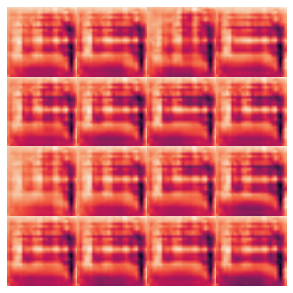

GENERATOR B


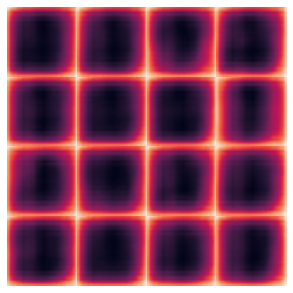

Epoch 91/100 Discriminator Loss: 2.7646248626708982 Generator Loss: 1.5587053140004477
Epoch 92/100 Discriminator Loss: 2.7646581888198853 Generator Loss: 1.5578782431284586
Epoch 93/100 Discriminator Loss: 2.764697216351827 Generator Loss: 1.5570498696962993
Epoch 94/100 Discriminator Loss: 2.7647416734695436 Generator Loss: 1.5562211338678995
Epoch 95/100 Discriminator Loss: 2.7647912867863975 Generator Loss: 1.555393810272217
Epoch 96/100 Discriminator Loss: 2.7648457272847495 Generator Loss: 1.5545692753791809
Epoch 97/100 Discriminator Loss: 2.7649046182632446 Generator Loss: 1.5537491075197856
Epoch 98/100 Discriminator Loss: 2.764967816670736 Generator Loss: 1.5529354898134868
Epoch 99/100 Discriminator Loss: 2.765035317738851 Generator Loss: 1.552130614121755
Epoch 100/100 Discriminator Loss: 2.765107035636902 Generator Loss: 1.5513361684481304
GENERATOR A


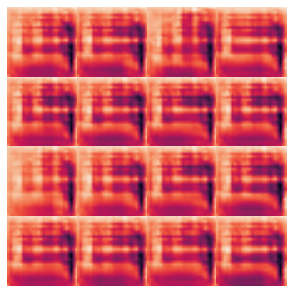

GENERATOR B


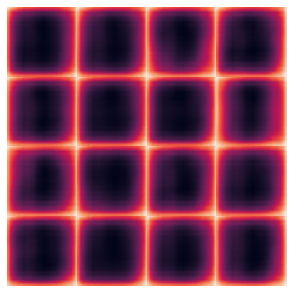

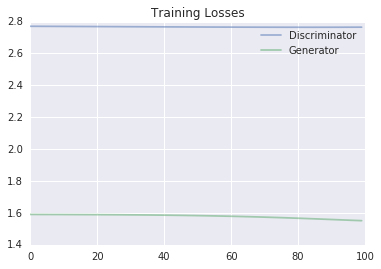

In [9]:
EPOCH = 100
BATCH_SIZE = 20
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = discoGAN()
sess.run(tf.global_variables_initializer())
train(model, sneakers, shirt, BATCH_SIZE, EPOCH)

You can see some output there, really need to tune sensitive hyper-parameters such as momentum value on adaptive + momentum on our generator optimizer, also maybe apply leaky relu and increase learning rate